# Example of SSD module.

This is a example usage of SSD module.

**SSD: Single Shot MultiBox Detector**  
Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy, Scott Reed, Cheng-Yang Fu, Alexander C. Berg  
https://arxiv.org/abs/1512.02325

### Over view of SSD
SSD is a real time object detection algorithm. Its arcitecture, shown as follows, allows to detect multi scale objects.

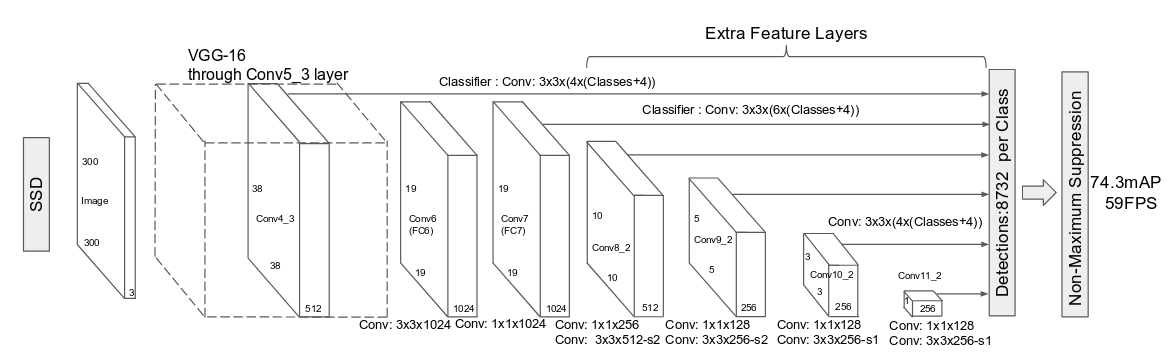

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import time
import random
import numpy as np
import renom as rm
from tqdm import tqdm
import matplotlib.pyplot as plt

from renom_img.api.detection.ssd import SSD
from renom_img.api.utility.augmentation import Augmentation
from renom_img.api.utility.augmentation.process import *
from renom_img.api.utility.load import parse_xml_detection
from renom_img.api.utility.misc.display import draw_box

from renom.cuda import set_cuda_active
set_cuda_active(True)

## Data preparation

**The PASCAL Visual Object Classes Homepage**  
http://host.robots.ox.ac.uk/pascal/VOC/

In [2]:
if not os.path.exists("VOCdevkit/VOC2007"):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
    !tar xfv VOCtrainval_06-Nov-2007.tar
    
if not os.path.exists("VOCdevkit/VOC2012"):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
    !tar xfv VOCtrainval_11-May-2012.tar

## Devide data into train and validation set.

In [3]:
image_voc_2007 = "VOCdevkit/VOC2007/JPEGImages/"
label_voc_2007 = "VOCdevkit/VOC2007/Annotations/"
image_voc_2012 = "VOCdevkit/VOC2012/JPEGImages/"
label_voc_2012 = "VOCdevkit/VOC2012/Annotations/"

train_voc_2007 = [line.strip() for line in open("VOCdevkit/VOC2007/ImageSets/Main/train.txt").readlines()]
train_voc_2007 += [line.strip() for line in open("VOCdevkit/VOC2007/ImageSets/Main/val.txt").readlines()]
train_voc_2012 = [line.strip() for line in open("VOCdevkit/VOC2012/ImageSets/Main/train.txt").readlines()]
valid_voc_2012 = [line.strip() for line in open("VOCdevkit/VOC2012/ImageSets/Main/val.txt").readlines()]

train_image_path_list = []
train_label_path_list = []
valid_image_path_list = []
valid_label_path_list = []

# Use training dataset of VOC2007, VOC2012 and validation dataset of 2007 as training data.
for path in train_voc_2007:
    train_image_path_list.append(os.path.join(image_voc_2007, path+'.jpg'))
    train_label_path_list.append(os.path.join(label_voc_2007, path+'.xml'))

for path in train_voc_2012:
    train_image_path_list.append(os.path.join(image_voc_2012, path+'.jpg'))
    train_label_path_list.append(os.path.join(label_voc_2012, path+'.xml'))

# Use validation dataset of VOC2012 as validation data.
for path in valid_voc_2012:
    valid_image_path_list.append(os.path.join(image_voc_2012, path+'.jpg'))
    valid_label_path_list.append(os.path.join(label_voc_2012, path+'.xml'))

train_annot, class_map = parse_xml_detection(train_label_path_list)
valid_annot, _ = parse_xml_detection(valid_label_path_list)

print("Dataset size")
print("  Train:{}".format(len(train_annot)))
print("  Valid:{}\n".format(len(valid_annot)))

print("Class list")
for i, name in enumerate(class_map):
    print("  {:02d} {}".format(i, name))

Dataset size
  Train:10728
  Valid:5823

Class list
  00 aeroplane
  01 bicycle
  02 bird
  03 boat
  04 bottle
  05 bus
  06 car
  07 cat
  08 chair
  09 cow
  10 diningtable
  11 dog
  12 horse
  13 motorbike
  14 person
  15 pottedplant
  16 sheep
  17 sofa
  18 train
  19 tvmonitor


## Initialize SSD model.

ReNomIMG provides SSD model. 
This module requires following arguments.

- class_map (list): List of class name.
- imsize (tuple): Image size. This is used for prediction. Currently(ReNomIMG v1.1.0), the size (300, 300) is accepted.
- load_pretrained_weight (bool): If this is True, pretrained weight will be downloaded and loaded.
- train_whole_network (bool): If this is True, backpropagation will be performed through whole net work.


In [4]:
model = SSD(class_map=class_map,
               load_pretrained_weight=True,
               train_whole_network=True)

### Train SSD model using 'fit function'.

The model object has `fit` method. It allows us to train SSD only giving image data path list and annotation list.
Following arguments can be give to `fit` method.

- train_img_path_list (list): Image path list used for training.
- train_annotation_list (list): Annotation list used for training.
- valid_img_path_list (list): Image path list used for validation.
- valid_annotation_list (list): Annotation list used for validation.
- epoch (int): Number of training epoch.
- batch_size (int): Number of batch size.
- imsize_list (list): List of image size. Image size must be muplitples of 32.
- augmentation (Augmentation): Augmentation object.
- callback_end_epoch (function): Given function will be called at end of epoch.

**Note**: Running following code with following parameters requires 11GB of GPU memory.

In [ ]:
root_path = "ssd_result"

def callback(*args):
    e, model = args[:2]
    path = random.choice(train_image_path_list)
    plt.clf()
    plt.imshow(draw_box(path, model.predict(path)))
    plt.savefig(os.path.join(root_path, "train%03d.png"%e))
    path = random.choice(valid_image_path_list)
    plt.clf()
    plt.imshow(draw_box(path, model.predict(path)))
    plt.savefig(os.path.join(root_path, "valid%03d.png"%e))
    if e and e%2 == 0:
        model.save(os.path.join(root_path, "model%03d.h5"%e))

model.fit(
    # Feeds image and annotation data.
    train_image_path_list,
    train_annot,
    valid_image_path_list,
    valid_annot,
    epoch=160,
    batch_size=16,
    augmentation=Augmentation([
        Rotate(),
        Shift(),
        Flip(),
        WhiteNoise(),
        ContrastNorm(),
    ]),
    callback_end_epoch=callback
)

Epoch:000 Avg Train Loss:10.870 Avg Valid Loss:8.361: 100%|██████████| 364/364 [08:40<00:00,  1.89it/s]
Epoch:001 Avg Train Loss:7.706 Avg Valid Loss:7.373: 100%|██████████| 364/364 [08:47<00:00,  1.82it/s]
Epoch:002 Avg Train Loss:7.084 Avg Valid Loss:6.801: 100%|██████████| 364/364 [08:43<00:00,  1.81it/s]
...
Epoch:148 Avg Train Loss:2.122 Avg Valid Loss:3.998: 100%|██████████| 364/364 [08:21<00:00,  1.94it/s]
Epoch:149 Avg Train Loss:2.114 Avg Valid Loss:4.004: 100%|██████████| 364/364 [08:20<00:00,  1.88it/s]
...


### Prediction

For using trained model, `model.predict` method can be used. This method requires following arguments.

- img_list (list, ndarray): Image path, list of image path or numpy array can be given.

If one image path is given, `predict` method returns following data. 
```python
[
    {  # 1st predicted object for input image path.
        "box":[x(float), y, w, h],  
        "score": confidencial_score(float),  
        "class": class_id(int),  
        "name": class_name(str)
    },
    {  # 2nd predicted object for input image path.
        "box":[x(float), y, w, h],  
        "score": confidencial_score(float),  
        "class": class_id(int),  
        "name": class_name(str)
    },
    ...
]  
```

If a list of image path or numpy array is given, `predict` method returns following data. 
```python
[
    [ # Predictions of 1st image.
        {  # 1st predicted object for 1st image path.
            "box":[x(float), y, w, h],  
            "score": confidencial_score(float),  
            "class": class_id(int),  
            "name": class_name(str),  
        },
        {  # 2nd predicted object for 1st image path.
            "box":[x, y, w, h],  
            "score": confidencial score(float),  
            "class": class_id(int),  
            "name": class_name(str),  
        },
    ],
    [ # Predictions of 2nd image.
        {  # 1st predicted object for 2nd image path.
            "box":[x(float), y, w, h],  
            "score": confidencial score(float),  
            "class": class_id(int),  
            "name": class_name(str),  
        },
        {  # 2nd predicted object for 2nd image path.
            "box":[x, y, w, h],  
            "score": confidencial score(float),  
            "class": class_id(int),  
            "name": class_name(str),  
        },
    ],
    ...
]
```

**Note**: The coordinate of box repesents ratio to the image size.
Therefore the range of predicted box coordinate is `0 <= x, y, w, h <= 1`.

ReNomIMG also provides draw bounding box function.
`renom_img.api.utility.misc.display.draw_box` can be used for show prediction result.
The function requires image path and prediction result.

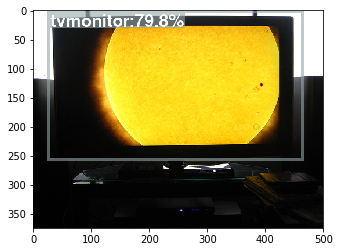

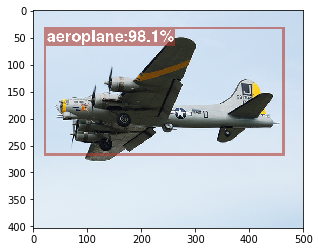

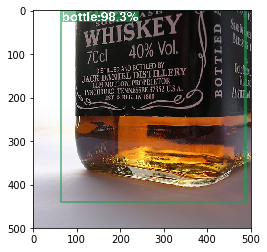

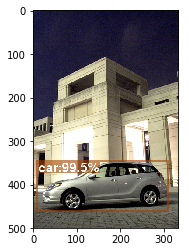

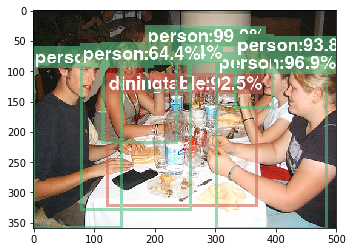

In [10]:
for i in range(5):
    path = valid_image_path_list[-i]
    # Output of predict method can be given directly.
    plt.imshow(draw_box(path, model.predict(path)))
    plt.show()

## 